In [1]:
%matplotlib inline

# Data Science with OpenStreetMap and Python

### Nikolai Janakiev [@njanakiev](http://twitter.com/njanakiev/)

# Working With OSM Data
- Attributes saved as Key-Value
- [Amenity key](https://wiki.openstreetmap.org/wiki/Key:amenity)

![OSM Key Amenity](assets/osm_key_amenity.png)

![taginfo](assets/taginfo.png)

# Loading Data from Taginfo

- Using the [Taginfo API](https://taginfo.openstreetmap.org/taginfo/apidoc)

In [2]:
import requests
import pandas as pd

key = 'amenity'
url = "https://taginfo.openstreetmap.org/api/4/key/values"
response = requests.get(url, params={
                'key':key, 
                'page':0, 'rp':100,
                'sortname':'count', 'sortorder':'desc'
            })
data = response.json()['data']

df = pd.DataFrame(data).set_index('value')
df[['count', 'description']].head()

,count,description
value,,
parking,2891252,A place for parking cars
place_of_worship,1023016,A place where religious services are conducted
school,969974,A primary or secondary school (pupils typicall...
bench,964951,A place for people to sit; allows room for sev...
restaurant,909128,A restaurant sells full sit-down meals with se...


# Distribution of Amenity Tags on Taginfo

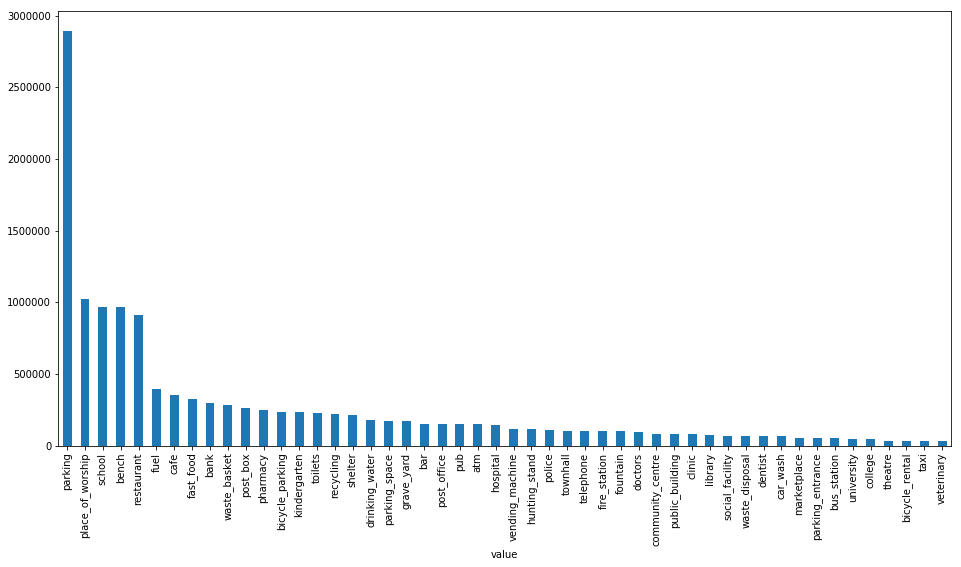

In [3]:
df.iloc[:50]['count'].plot(kind='bar', figsize=(16, 8), color='C0');

# Loading Data from OpenStreetMap

- Using the [Overpass API](https://wiki.openstreetmap.org/wiki/Overpass_API) and the [Overpass QL](https://wiki.openstreetmap.org/wiki/Overpass_API/Overpass_QL)

In [4]:
import requests

overpass_url = "http://overpass-api.de/api/interpreter"
overpass_query = """
    [out:json];
    area["ISO3166-1"="AT"][admin_level=2]->.search;
    node[amenity="restaurant"](area.search);
    out count;"""
response = requests.get(overpass_url, params={'data': overpass_query})
response.json()

{'elements': [{'id': 0,
   'tags': {'areas': '0',
    'nodes': '11910',
    'relations': '0',
    'total': '11910',
    'ways': '0'},
   'type': 'count'}],
 'generator': 'Overpass API 0.7.55.4 3079d8ea',
 'osm3s': {'copyright': 'The data included in this document is from www.openstreetmap.org. The data is made available under ODbL.',
  'timestamp_areas_base': '2018-10-09T12:01:02Z',
  'timestamp_osm_base': '2018-10-09T12:58:02Z'},
 'version': 0.6}

# PostGIS

- Geospatial Extension for [PostgreSQL](https://www.postgresql.org/)

## Spatial Types

- geometry, geography

## Spatial Indexes

- r-tree, quad-tree, kd-tree

## Spatial Functions

- ST_Length(geometry), ST_X(geometry)

## Create a Table


    CREATE TABLE osm_boundaries (
        osm_id BIGINT PRIMARY KEY,
        country_code VARCHAR(2), 
        amenity INTEGER,
        name VARCHAR,
        polygon GEOGRAPHY);

## Insert an Entry


    INSERT INTO osm_amenities 
        VALUES (
            2415889355, 
            'AT', 
            'university', 
            'Department of Geoinformatics - Z_GIS', 
            ST_GeogFromText('Point (13.0610593 47.7885778)')
        )

# GeoPandas

- Dataframes with a geospatial column
- Geospatial extension for [Pandas](http://pandas.pydata.org/)
- Uses [shapely](http://toblerity.org/shapely/manual.html) for geometric operations and [fiona](https://github.com/Toblerity/Fiona) for file acces
- Visualization depends on [descartes](https://bitbucket.org/sgillies/descartes/) and [matplotlib](https://matplotlib.org/)

# Loading PostGIS Table with Python and GeoPandas

In [5]:
import psycopg2
import geopandas as gpd

with psycopg2.connect(database="osm_data_science_db", user="postgres", 
                      password='password', host='localhost') as connection:
    gdf = gpd.GeoDataFrame.from_postgis("""SELECT * FROM osm_amenities_areas""", 
            connection, geom_col='geom')
gdf[['osm_id', 'amenity', 'state', 'geom']].head()

,osm_id,amenity,state,geom
0,476,university,Steiermark,POINT (15.4498326391065 47.0777236761512)
1,11101,townhall,Wien,POINT (16.3573412415296 48.2108412144281)
2,11936,school,Wien,POINT (16.4103468335947 48.2842460993475)
3,14604,school,Niederösterreich,POINT (16.778381402358 48.0259891360606)
4,27945,school,Wien,POINT (16.2909158154218 48.1690868739775)


# All Amenities in Austria

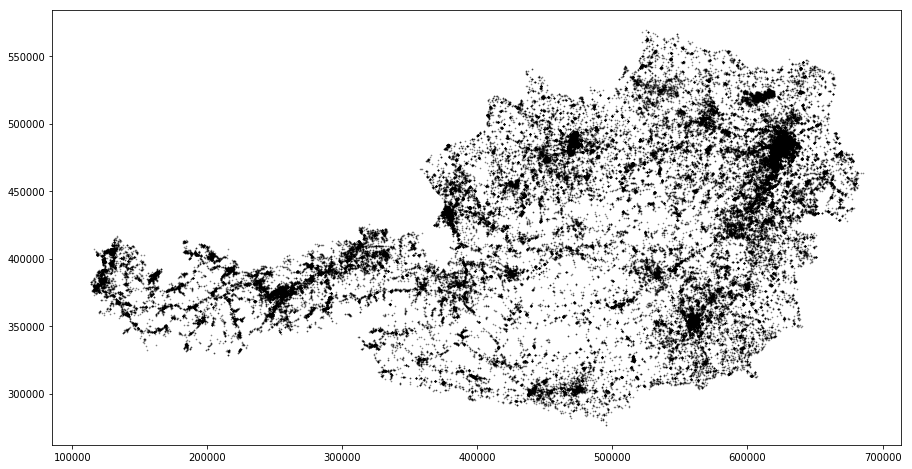

In [6]:
gdf.to_crs({'init': 'epsg:31287'}).plot(
    figsize=(16, 8), alpha=0.4, markersize=0.5, color='k');

# Which State has the most Cafes, Benches, Restaurants, ...?

In [7]:
df_counts = gdf.groupby(['state', 'amenity']).count().reset_index()
df_counts = df_counts.pivot(index='state', columns='amenity', values='osm_id')
df_counts = df_counts.fillna(0).astype('int')
df_counts

amenity,atm,bank,bar,bench,bicycle_parking,bicycle_rental,bus_station,cafe,car_wash,clinic,...,taxi,telephone,theatre,toilets,townhall,university,vending_machine,veterinary,waste_basket,waste_disposal
state,,,,,,,,,,,,,,,,,,,,,
Burgenland,60,100,32,713,48,15,4,99,18,0,...,5,59,4,86,57,1,44,15,131,11
Kärnten,95,170,135,1358,115,11,3,381,17,4,...,12,196,14,169,38,4,125,28,374,15
Niederösterreich,259,606,146,8482,612,127,34,540,87,4,...,36,710,30,471,233,12,555,101,2127,43
Oberösterreich,196,517,165,3891,346,19,35,492,62,4,...,25,410,22,387,396,5,588,60,764,23
Salzburg,154,202,160,3928,217,7,8,276,33,5,...,46,207,19,291,37,14,410,26,518,11
Steiermark,213,388,175,6408,1424,16,37,734,105,6,...,54,368,26,389,91,24,974,71,1577,58
Tirol,196,312,237,7765,270,53,24,498,43,0,...,33,362,29,384,255,3,927,27,1030,12
Vorarlberg,60,123,65,1958,127,0,10,122,20,0,...,6,97,8,103,48,2,205,4,170,2
Wien,292,303,330,3290,2190,141,4,1044,35,13,...,154,1054,57,272,5,53,707,79,2125,40


# Load Population with Wikidata

In [8]:
import requests

url = 'https://query.wikidata.org/sparql'
query = """
SELECT ?state ?stateLabel ?population WHERE {
  ?state wdt:P31 wd:Q261543.
  ?state wdt:P1082 ?population. 
  SERVICE wikibase:label { bd:serviceParam wikibase:language "de". }
}
"""

response = requests.get(url, params = {'format': 'json', 'query': query})
data = response.json()
data = [(binding['stateLabel']['value'], int(binding['population']['value'])) 
         for binding in data['results']['bindings']]

df_pop = pd.DataFrame(data, columns=['state', 'population'])
df_pop = df_pop.set_index('state')
df_pop = df_pop.sort_values(by='population')

# What are the most common Amenities per State?

In [9]:
df_counts_normalized = df_counts.apply(lambda row: row / df_pop.loc[row.name].values, axis=1)

max_counts = df_counts_normalized.idxmax(axis=0)
for state in df_pop.index:
    print(state)
    print(list(max_counts[max_counts == state].index))
    print()

Burgenland
['college', 'fuel', 'post_office']

Vorarlberg
['parking_entrance']

Salzburg
['atm', 'clinic', 'dentist', 'hospital', 'post_box', 'pub', 'taxi', 'toilets']

Kärnten
['cafe', 'grave_yard', 'police', 'public_building']

Tirol
['bank', 'bar', 'bench', 'bus_station', 'community_centre', 'drinking_water', 'fire_station', 'fountain', 'marketplace', 'parking', 'restaurant', 'school', 'social_facility', 'theatre', 'townhall', 'vending_machine', 'waste_basket']

Steiermark
['car_wash', 'doctors', 'library', 'parking_space', 'waste_disposal']

Oberösterreich
['recycling', 'shelter']

Niederösterreich
['bicycle_rental', 'hunting_stand', 'kindergarten', 'place_of_worship', 'veterinary']

Wien
['bicycle_parking', 'fast_food', 'pharmacy', 'telephone', 'university']



# What is the most 'French' City?

- Using simple data science methods and OpenStreetMap to model culture

# Load and Prepare the Data Set

In [10]:
import psycopg2
import geopandas as gpd

with psycopg2.connect(database="osm_data_science_db", user="postgres", 
                      password='password', host='localhost') as connection:
    gdf = gpd.GeoDataFrame.from_postgis("""SELECT * FROM city_amenity_counts""", 
            connection, geom_col='geom')

# Unique country codes
gdf['country_code'].unique()

array(['AT', 'CH', 'DE', 'FR'], dtype=object)

In [11]:
# Get only Germany and France
gdf_DE_FR = gdf[(gdf['country_code'] == 'DE') | \
                (gdf['country_code'] == 'FR')].copy()

### Select the Feature Vectors

In [12]:
X = gdf_DE_FR.loc[:, 'parking':'veterinary'].values
y = gdf_DE_FR['country_code'].map({'DE': 0, 'FR': 1}).values

# Train our Model

### Logistic Regression Model

In [13]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=1000)

clf = LogisticRegressionCV(cv=5)
clf.fit(X_train, y_train)

LogisticRegressionCV(Cs=10, class_weight=None, cv=5, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
           refit=True, scoring=None, solver='lbfgs', tol=0.0001, verbose=0)

In [14]:
print('Training score : {:.4f}'.format(clf.score(X_train, y_train)))
print('Testing score  : {:.4f}'.format(clf.score(X_test, y_test)))

Training score : 0.8936
Testing score  : 0.8293


# Most 'French' Austrian City?

In [15]:
gdf_AT = gdf[gdf['country_code'] == 'AT']
X_AT = gdf_AT.loc[:, 'parking':'veterinary'].values

In [16]:
for city, prediction, proba in zip(gdf_AT['city'], clf.predict(X_AT), clf.predict_proba(X_AT)[:, 1]):
    print('{:12s} {},  {:.3f}'.format(city, 'German' if prediction == 0 else 'French', proba))

Wien         French,  0.561
Graz         German,  0.313
Linz         French,  0.970
Salzburg     German,  0.281
Innsbruck    German,  0.434
Klagenfurt   German,  0.464


# Visualize a Map of most 'French' Cities

In [17]:
gdf['frenchness'] = gdf.loc[:, 'parking':'veterinary'].apply(
    lambda row: clf.predict_proba([row.values])[:, 1][0], axis=1)

In [18]:
# Normalize between 0 and 1
f = gdf['frenchness']
gdf['frenchness'] = (f - f.min()) / (f.max() - f.min())

# Visualize with Folium

In [21]:
import folium
import matplotlib

cmap = matplotlib.cm.get_cmap('cool', 5)

m = folium.Map(location=[49.5734053, 7.588576], zoom_start=5)
for i, row in gdf.iterrows():

    rgb = cmap(row['frenchness'])[:3]
    hex_color = matplotlib.colors.rgb2hex(rgb)
    
    folium.CircleMarker([row['geom'].y, row['geom'].x], 
                        radius=5,
                        popup=row['city'], 
                        fill_color=hex_color,
                        fill_opacity=1,
                        opacity=0.0).add_to(m)
m.save('maps/folium_map.html')

In [22]:
from IPython.display import IFrame

IFrame('maps/folium_map.html', width=1024, height=600)

![folium visualization](assets/folium_map.png)

# Data Science with OpenStreetMap and Python

### Nikolai Janakiev [@njanakiev](http://twitter.com/njanakiev/)

## Resources

- [Loading Data from OpenStreetMap with Python and the Overpass API](https://janakiev.com/blog/openstreetmap-with-python-and-overpass-api/)
- [Predict Economic Indicators with OpenStreetMap](https://janakiev.com/blog/osm-predict-economic-indicators/)
- [Python GDAL/OGR Cookbook](https://pcjericks.github.io/py-gdalogr-cookbook/)
- [PostGIS](https://postgis.net/)
- [GeoPandas](http://geopandas.org/index.html), [Pandas](https://pandas.pydata.org/)
- [Folium](https://python-visualization.github.io/folium/)